In [1]:
import keras_tuner
import numpy as np
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from wittgenstein import RIPPER
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from scipy.stats import randint as sp_randint
from sklearn.metrics import (make_scorer, accuracy_score, precision_score,
                             recall_score, f1_score, precision_recall_fscore_support, 
                             classification_report, confusion_matrix, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

import keras
import keras_tuner

2024-01-06 00:40:10.011271: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-06 00:40:10.011500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-06 00:40:10.089472: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-06 00:40:10.233996: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-06 00:40:11.248542: W tensorflow/compiler/tf2

# 1 Data Preprocessing

## 1.1 Handling categorical attirbute

In [19]:
original_dataset = pd.read_csv("data/final_dataset.csv")
original_dataset.head()

,date,year,city_or_county,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,teen_ratio,adults_ratio,...,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,month_x,month_y
0,729.0,2015.0,Indianapolis,39.8322,-86.2492,19.0,19.0,19.0,0.0,1.0,...,False,False,False,False,False,False,False,False,5.000000e-01,-0.866025
1,1459.0,2017.0,Kane,41.6645,-78.7856,62.0,62.0,62.0,0.0,1.0,...,False,False,False,False,False,False,False,False,8.660254e-01,-0.500000
2,1404.0,2016.0,Detroit,42.4190,-83.0393,19.0,19.0,19.0,0.0,1.0,...,False,False,False,False,False,False,False,False,-5.000000e-01,0.866025
3,1383.0,2016.0,Washington,38.9030,-76.9820,21.0,21.0,21.0,0.0,1.0,...,False,False,False,False,False,False,False,False,-8.660254e-01,0.500000
4,894.0,2015.0,Pittsburgh,40.4621,-80.0308,21.0,21.0,21.0,0.0,1.0,...,False,False,False,False,False,False,False,False,1.224647e-16,-1.000000


In [20]:
state_cols = [n for n in original_dataset.columns if n.startswith('state')]
state_cols.remove('state_population')

original_dataset = original_dataset.drop(columns=state_cols)
original_dataset = original_dataset.drop(columns=['city_or_county', 'min_age_participants', 'avg_age_participants', 'max_age_participants', 'unharmed_ratio', 'dead/murder/suicide'])

original_dataset.head()

,date,year,latitude,longitude,teen_ratio,adults_ratio,males_ratio,killed_ratio,injured_ratio,arrested_ratio,n_participants,povertyPercentage,party,totalvotes,republicans_ratio,democrats_ratio,state_population,populous_city,month_x,month_y
0,729.0,2015.0,39.8322,-86.2492,0.0,1.0,1.0,0.0,1.0,0.0,1.0,12.3,0,112261.0,0.452677,0.547323,6611442,0,5.000000e-01,-0.866025
1,1459.0,2017.0,41.6645,-78.7856,0.0,1.0,1.0,1.0,0.0,0.0,1.0,10.5,1,307843.0,0.671644,0.328356,12794679,0,8.660254e-01,-0.500000
2,1404.0,2016.0,42.4190,-83.0393,0.0,1.0,1.0,0.0,0.5,0.0,2.0,11.0,0,310974.0,0.214934,0.785066,9954117,0,-5.000000e-01,0.866025
3,1383.0,2016.0,38.9030,-76.9820,0.0,1.0,1.0,0.0,1.0,0.0,2.0,14.9,1,296385.0,0.691398,0.308602,687576,0,-8.660254e-01,0.500000
4,894.0,2015.0,40.4621,-80.0308,0.0,1.0,1.0,0.0,0.5,0.0,2.0,11.5,0,148351.0,0.000000,1.000000,12789838,0,1.224647e-16,-1.000000


In [21]:
labels = original_dataset.pop('killed_ratio')
labels = (labels.to_numpy() > 0).astype('int')

In [22]:
_, count = np.unique(labels, return_counts=True)
print(count)
print(count[0] / (count[0] + count[1]))

[181421  57960]
0.7578755206135825


In [23]:
scaled_dataset = pd.DataFrame.copy(original_dataset).to_numpy()

scaler = StandardScaler()
scaled_dataset = scaler.fit_transform(scaled_dataset)
scaled_dataset

array([[-0.98813652, -0.57958268,  0.44285341, ...,  0.        ,
         0.68989202, -1.22704931],
       [ 0.65869655,  1.04955081,  0.79973844, ...,  0.        ,
         1.20385901, -0.7056087 ],
       [ 0.53462008,  0.23498407,  0.94669568, ...,  0.        ,
        -0.71429189,  1.24043416],
       ...,
       [ 1.17756176,  1.04955081, -0.4787214 , ...,  0.        ,
        -1.22825888, -0.7056087 ],
       [ 0.19397379,  0.23498407,  0.24669617, ...,  0.        ,
        -0.01219994, -1.41790982],
       [ 0.20525347,  0.23498407,  0.44571659, ...,  0.        ,
        -0.01219994, -1.41790982]])

# 2 Utilities for measuring metrics scores

In [24]:
def report_metrics_best_estimator(train_label, train_pred, test_label, test_pred):
    print('Accuracy train set ', accuracy_score(train_label, train_pred))
    print('Accuracy test set ', accuracy_score(test_label, test_pred))
    print('Precision train set ', precision_score(train_label, train_pred, average='weighted'))
    print('Precision test set ', precision_score(test_label, test_pred, average='weighted'))
    print('Recall train set ', recall_score(train_label, train_pred, average='weighted'))
    print('Recall test set ', recall_score(test_label, test_pred, average='weighted'))
    print('F1 score train set ', f1_score(train_label, train_pred, average='weighted'))
    print('F1 score test set ', f1_score(test_label, test_pred, average='weighted'))
    print('Support train set ', precision_recall_fscore_support(train_label, train_pred))
    print('Support test set ', precision_recall_fscore_support(test_label, test_pred))

In [25]:
def report_scores(test_label, test_pred):
    print(classification_report(test_label,
                                test_pred,
                                target_names=['No Killed', 'Killed']))

In [26]:
def report_confusion_matrix(test_label, test_pred):
    cm = confusion_matrix(test_label, test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Killed', 'Killed'])
    disp.plot()
    plt.show()

# 3 Decision Tree

In [27]:
train_set, test_set, train_label, test_label = train_test_split(original_dataset, labels, stratify=labels, test_size=0.20)

undersample = RandomUnderSampler(sampling_strategy='majority')
train_set, train_label = undersample.fit_resample(train_set, train_label)

In [28]:
decision_tree = DecisionTreeClassifier()
param_dist = { "criterion": ["gini", "entropy"],
               "max_depth": [3, 5, 7, 10, None],
               "min_samples_split": sp_randint(20, 51),
               "min_samples_leaf": sp_randint(20, 51)}

random_search = RandomizedSearchCV(decision_tree, 
                                   param_distributions=param_dist,
                                   n_iter=20,
                                   n_jobs=-1,
                                   scoring=make_scorer(accuracy_score))

random_search.fit(train_set, train_label)

RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 7, 10, None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f340c83db70>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f340c83d630>},
                   scoring=make_scorer(accuracy_score))

In [29]:
best_dt = random_search.best_estimator_
best_dt_hp = random_search.cv_results_['params'][0]
print('Best setting parameters ', best_dt_hp)
print('Mean and std of this setting ', random_search.cv_results_['mean_test_score'][0],
      random_search.cv_results_['std_test_score'][0])

Best setting parameters  {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 20}
Mean and std of this setting  0.8322981712181441 0.002014919583647974


In [30]:
train_pred = best_dt.predict(train_set)
test_pred = best_dt.predict(test_set)

In [31]:
report_metrics_best_estimator(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.8363095238095238
Accuracy test set  0.7910896672723855
Precision train set  0.8455138277668531
Precision test set  0.862158507196535
Recall train set  0.8363095238095238
Recall test set  0.7910896672723855
F1 score train set  0.8352120581049615
F1 score test set  0.8049572153524388
Support train set  (array([0.90190722, 0.78912044]), array([0.75470152, 0.91791753]), array([0.82176404, 0.84866007]), array([46368, 46368]))
Support test set  (array([0.96490607, 0.54054054]), array([0.75168803, 0.91442374]), array([0.84505515, 0.67944363]), array([36285, 11592]))


In [32]:
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

   No Killed       0.96      0.75      0.85     36285
      Killed       0.54      0.91      0.68     11592

    accuracy                           0.79     47877
   macro avg       0.75      0.83      0.76     47877
weighted avg       0.86      0.79      0.80     47877


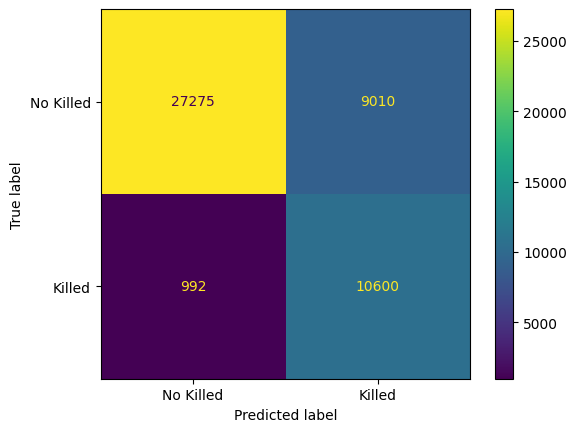

In [33]:
report_confusion_matrix(test_label, test_pred)

# 3 Random Forest

In [34]:
random_forest = RandomForestClassifier(n_estimators=10)
param_dist = {"max_depth": [3, 5, 7, 10, None],
              "max_features": sp_randint(1, train_set.shape[0] + 1),
              "min_samples_split": sp_randint(20, 51),
              "min_samples_leaf": sp_randint(20, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"]}

random_search = RandomizedSearchCV(random_forest, param_distributions=param_dist,
                                 n_iter=10,
                                 n_jobs=-1,
                                 scoring=make_scorer(accuracy_score))

random_search.fit(train_set, train_label)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=10), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [3, 5, 7, 10, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f34040f54b0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f34040f7bb0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f34040f6740>},
                   scoring=make_scorer(accuracy_score))

In [35]:
best_rf = random_search.best_estimator_
best_rf_hp = random_search.cv_results_['params'][0]
print('Best setting parameters ', best_rf_hp)
print('Mean and std of this setting ', random_search.cv_results_['mean_test_score'][0],
      random_search.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 82774, 'min_samples_leaf': 40, 'min_samples_split': 42}
Mean and std of this setting  0.8291278576413397 0.001426585299715434


In [36]:
train_pred = best_rf.predict(train_set)
test_pred = best_rf.predict(test_set)

In [37]:
report_metrics_best_estimator(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.8535196687370601
Accuracy test set  0.7996115044802306
Precision train set  0.8615253860804661
Precision test set  0.8646903006471884
Recall train set  0.8535196687370601
Recall test set  0.7996115044802306
F1 score train set  0.8527042292465475
F1 score test set  0.8125949147428545
Support train set  (array([0.91532381, 0.80772697]), array([0.77911491, 0.92792443]), array([0.84174472, 0.86366374]), array([46368, 46368]))
Support test set  (array([0.96453061, 0.55217255]), array([0.76367645, 0.91209455]), array([0.85243178, 0.6878985 ]), array([36285, 11592]))


In [38]:
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

   No Killed       0.96      0.76      0.85     36285
      Killed       0.55      0.91      0.69     11592

    accuracy                           0.80     47877
   macro avg       0.76      0.84      0.77     47877
weighted avg       0.86      0.80      0.81     47877


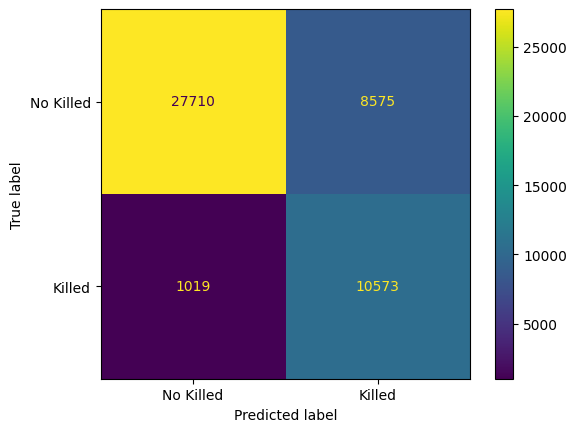

In [39]:
report_confusion_matrix(test_label, test_pred)

# 4 RIPPER

In [65]:
ripper = RIPPER()
param_dist = {"prune_size": [0.5, 0.6, 0.7], "k": [1, 3, 5]}

grid_search = GridSearchCV(ripper, 
                           param_grid=param_dist,
                           n_jobs=-1,
                           scoring=make_scorer(accuracy_score))

grid_search.fit(train_set, train_label)

GridSearchCV(estimator=<RIPPER(max_rules=None, dl_allowance=64, prune_size=0.33, n_discretize_bins=10, max_total_conds=None, max_rule_conds=None, k=2, alpha=1.0, random_state=None, verbosity=0)>,
             n_jobs=-1,
             param_grid={'k': [1, 3, 5], 'prune_size': [0.5, 0.6, 0.7]},
             scoring=make_scorer(accuracy_score))

In [67]:
best_ripper = grid_search.best_estimator_
best_ripper_hp = grid_search.cv_results_['params'][0]
print('Best setting parameters ', best_ripper_hp)
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0],
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'k': 1, 'prune_size': 0.5}
Mean and std of this setting  0.9522084019035786 0.0017607054479765653


In [68]:
train_pred = best_ripper.predict(train_set)
test_pred = best_ripper.predict(test_set)

In [69]:
report_metrics_best_estimator(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.951529071773637
Accuracy test set  0.9503968253968254
Precision train set  0.9549572678141443
Precision test set  0.9539530477944085
Recall train set  0.951529071773637
Recall test set  0.9503968253968254
F1 score train set  0.9514375898510655
F1 score test set  0.9502994881974705
Support train set  (array([0.91546445, 0.99445009]), array([0.99493185, 0.90812629]), array([0.95354533, 0.94932985]), array([46368, 46368]))
Support test set  (array([0.91377397, 0.99413212]), array([0.99465148, 0.90614217]), array([0.95249897, 0.94810001]), array([11592, 11592]))


In [70]:
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

   No Killed       0.91      0.99      0.95     11592
      Killed       0.99      0.91      0.95     11592

    accuracy                           0.95     23184
   macro avg       0.95      0.95      0.95     23184
weighted avg       0.95      0.95      0.95     23184


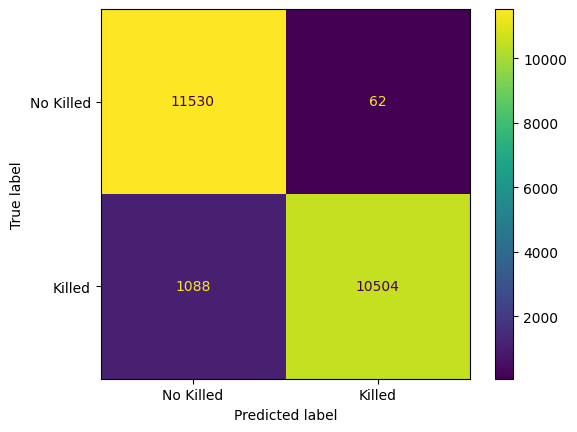

In [71]:
report_confusion_matrix(test_label, test_pred)

# 5 K-nn

In [40]:
train_set, test_set, train_label, test_label = train_test_split(scaled_dataset, labels, stratify=labels, test_size=0.20)

undersample = RandomUnderSampler(sampling_strategy='majority')
train_set, train_label = undersample.fit_resample(train_set, train_label)

In [41]:
knn = KNeighborsClassifier(algorithm='ball_tree', metric='minkowski')
param_dist = {"n_neighbors": [1, 3, 5, 10, 20]}

grid_search = GridSearchCV(knn, param_grid=param_dist,
                                 n_jobs=-1,
                                 scoring=make_scorer(accuracy_score))

grid_search.fit(train_set, train_label)

KeyboardInterrupt: 

In [25]:
best_knn = grid_search.best_estimator_
best_knn_hp = grid_search.cv_results_['params'][0]
print('Best setting parameters ', best_knn_hp)
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0],
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'class_weight': {0: 0.3, 1: 0.7}, 'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 22, 'min_samples_split': 19}
Mean and std of this setting  0.8120979386654413 0.0049045049216736095


In [26]:
train_pred = best_knn.predict(train_set)
test_pred = best_knn.predict(test_set)

In [27]:
report_metrics_best_estimator(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.847595872671067
Accuracy test set  0.8394009649727426
Precision train set  0.8460612630452131
Recall train set  0.847595872671067
F1 score train set  0.8467715567294166
Support train set  (array([0.89563065, 0.69040448]), array([0.90446062, 0.66903038]), array([0.90002398, 0.6795494 ]), array([145249,  46255]))


In [28]:
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

   No Killed       0.89      0.90      0.89     36313
      Killed       0.67      0.65      0.66     11564

    accuracy                           0.84     47877
   macro avg       0.78      0.78      0.78     47877
weighted avg       0.84      0.84      0.84     47877


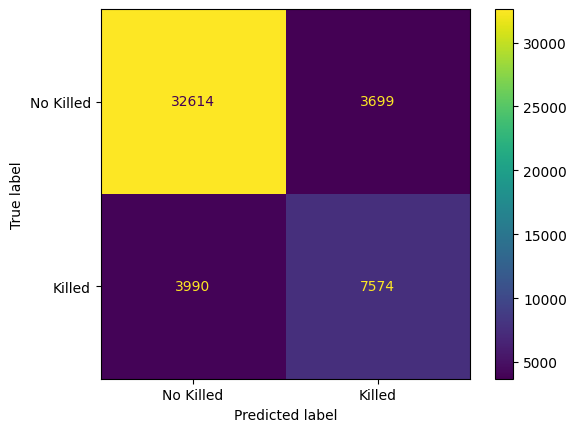

In [29]:
report_confusion_matrix(test_label, test_pred)

# 6 Naive Bayes

In [79]:
naiveBayes = GaussianNB()

#run the grid search
naiveBayes.fit(train_set, train_label)

GaussianNB()

In [80]:
train_pred = naiveBayes.predict(train_set)
test_pred = naiveBayes.predict(test_set)

In [81]:
report_metrics_best_estimator(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.9507850241545893
Accuracy test set  0.9524240855762595
Precision train set  0.9536832138849393
Precision test set  0.9551250377918687
Recall train set  0.9507850241545893
Recall test set  0.9524240855762595
F1 score train set  0.9507063004496806
F1 score test set  0.9523533955508999
Support train set  (array([0.91742222, 0.98994421]), array([0.99074793, 0.91082212]), array([0.95267622, 0.94873638]), array([46368, 46368]))
Support test set  (array([0.92006408, 0.990186  ]), array([0.99094203, 0.91390614]), array([0.95418864, 0.95051815]), array([11592, 11592]))


In [82]:
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

   No Killed       0.92      0.99      0.95     11592
      Killed       0.99      0.91      0.95     11592

    accuracy                           0.95     23184
   macro avg       0.96      0.95      0.95     23184
weighted avg       0.96      0.95      0.95     23184


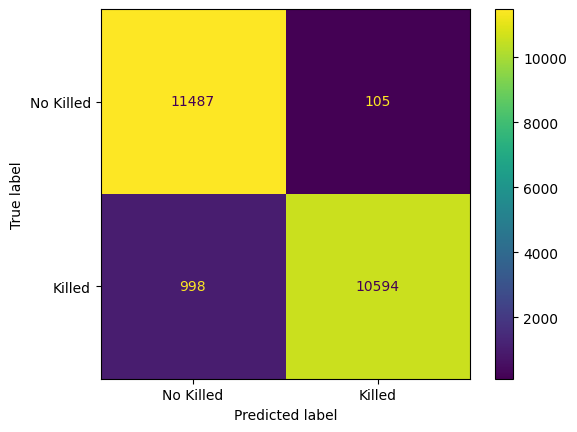

In [83]:
report_confusion_matrix(test_label, test_pred)

# 7 SVC

In [84]:
svc = SVC()
param_dist = {"C": [1e-1, 1, 10],
              "kernel": ["rbf", "linear", "poly"]}


grid_search = GridSearchCV(svc, param_grid=param_dist,
                                n_jobs=-1,
                                scoring=make_scorer(accuracy_score))

grid_search.fit(train_set, train_label)

KeyboardInterrupt: 

In [ ]:
best_svc = grid_search.best_estimator_
best_svc_hp = grid_search.cv_results_['params'][0]
print('Best setting parameters ', best_svc_hp)
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0],
      grid_search.cv_results_['std_test_score'][0])

In [ ]:
train_pred = best_svc.predict(train_set)
test_pred = best_svc.predict(test_set)

In [ ]:
report_metrics_best_estimator(train_label, train_pred, test_label, test_pred)

In [ ]:
report_scores(test_label, test_pred)

In [ ]:
report_confusion_matrix(test_label, test_pred)

# 8 Neural Network

In [85]:
train_set, val_set, train_label, val_label = train_test_split(train_set, train_label, stratify=train_label, test_size=0.20)

In [86]:
def build_model(hp):
    activation_f = hp.Choice('activation', ['tanh', 'sigmoid', 'relu'])
    max_layer = 5
    units_per_layer = []
    
    for i in range(max_layer - 1):
        units_per_layer.append(hp.Int('units_' + str(i), min_value=5, max_value=50, step=5))
    
    model = keras.Sequential()

    # Tune the number of layers and units in each layer
    for i in range(hp.Int('num_layers', min_value=2, max_value=max_layer, step=1) - 1):
        model.add(keras.layers.Dense(units=units_per_layer[i],
                               activation=activation_f))

    # Output layer with a single unit and sigmoid activation (for binary classification)
    model.add(keras.layers.Dense(units=1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.5, 0.1, 0.001, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [93]:
tuner = keras_tuner.RandomSearch(build_model,
                                 objective='val_accuracy',
                                 max_trials=5,
                                 directory='nn_tuning',
                                 project_name='sequential_classifier')

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

tuner.search(train_set, train_label,
             epochs=100,
             batch_size=1000,
             callbacks=[early_stopping],
             validation_data=(val_set, val_label))

Trial 5 Complete [00h 00m 10s]
val_accuracy: 0.5

Best val_accuracy So Far: 0.9525555372238159
Total elapsed time: 00h 01m 10s


In [100]:
best_nn_hp = tuner.get_best_hyperparameters()[0]
best_nn = build_model(best_nn_hp)

history = best_nn.fit(train_set, train_label,
                      epochs=100,
                      batch_size=1000,
                      callbacks=[early_stopping],
                      validation_data=(val_set, val_label))

Epoch 1/100
75/75 [==============================] - 1s 4ms/step - loss: 0.5552 - accuracy: 0.7778 - val_loss: 0.3887 - val_accuracy: 0.9406
Epoch 2/100
75/75 [==============================] - 0s 2ms/step - loss: 0.2909 - accuracy: 0.9504 - val_loss: 0.2316 - val_accuracy: 0.9486
Epoch 3/100
75/75 [==============================] - 0s 2ms/step - loss: 0.2043 - accuracy: 0.9515 - val_loss: 0.1915 - val_accuracy: 0.9486
Epoch 4/100
75/75 [==============================] - 0s 2ms/step - loss: 0.1774 - accuracy: 0.9516 - val_loss: 0.1741 - val_accuracy: 0.9489
Epoch 5/100
75/75 [==============================] - 0s 2ms/step - loss: 0.1637 - accuracy: 0.9516 - val_loss: 0.1640 - val_accuracy: 0.9487
Epoch 6/100
75/75 [==============================] - 0s 2ms/step - loss: 0.1550 - accuracy: 0.9514 - val_loss: 0.1570 - val_accuracy: 0.9490
Epoch 7/100
75/75 [==============================] - 0s 2ms/step - loss: 0.1492 - accuracy: 0.9517 - val_loss: 0.1520 - val_accuracy: 0.9492
Epoch 8/100
7

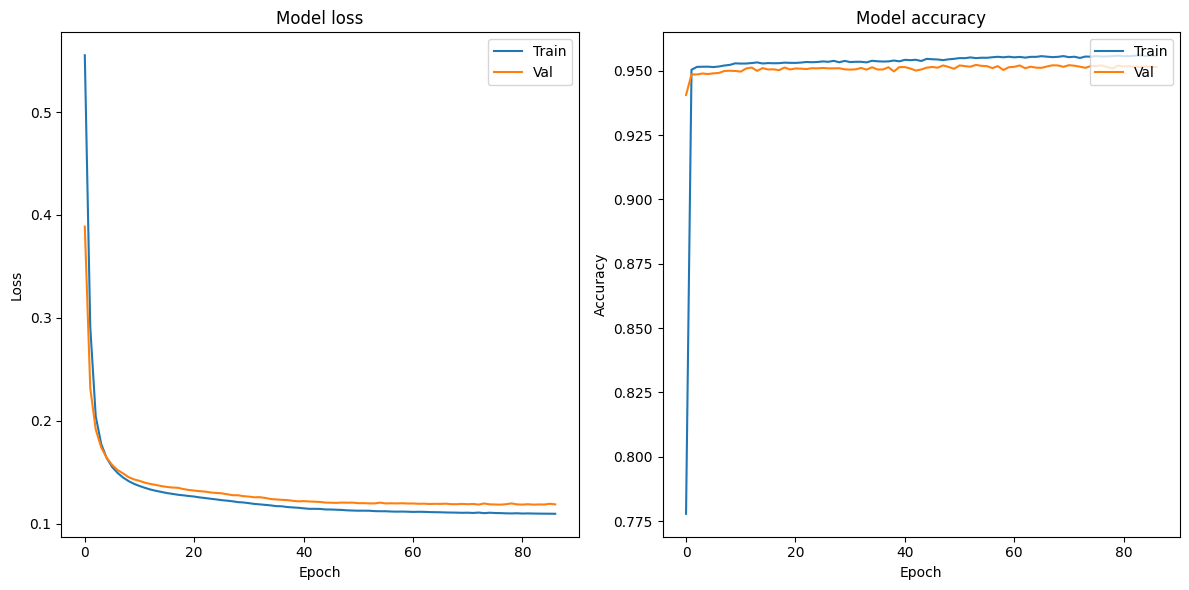

In [101]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
print('Best setting parameters ', tuner.get_best_hyperparameters()[0])

In [ ]:
train_pred = best_nn(train_set) > 0.5
test_pred = best_nn(test_set) > 0.5

In [ ]:
report_metrics_best_estimator(train_label, train_pred, test_label, test_pred)

In [ ]:
report_scores(test_label, test_pred)

In [ ]:
report_confusion_matrix(test_label, test_pred)

# Ensamble with best models

In [113]:
train_set, test_set, train_label, test_label = train_test_split(original_dataset, labels, stratify=labels, test_size=0.20)

undersample = RandomUnderSampler(sampling_strategy='majority')
train_set, train_label = undersample.fit_resample(train_set, train_label)

In [115]:
ada_boost = AdaBoostClassifier(estimator=DecisionTreeClassifier(**best_dt_hp), n_estimators=100, learning_rate=0.1)
ada_boost.fit(train_set, train_label)

/home/filippo/uni/DM/DataMiningProject/venv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=7,
                                                         min_samples_leaf=23,
                                                         min_samples_split=23),
                   learning_rate=0.1, n_estimators=100)

In [116]:
train_pred = ada_boost.predict(train_set)
test_pred = ada_boost.predict(test_set)

In [117]:
report_metrics_best_estimator(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.9693969979296067
Accuracy test set  0.956219806763285
Precision train set  0.9704197260006093
Precision test set  0.9575498989844587
Recall train set  0.9693969979296067
Recall test set  0.956219806763285
F1 score train set  0.9693803555737762
F1 score test set  0.9561879664956513
Support train set  (array([0.94848547, 0.99235398]), array([0.99271049, 0.94608351]), array([0.97009421, 0.9686665 ]), array([46368, 46368]))
Support test set  (array([0.93288041, 0.98221939]), array([0.98317805, 0.92926156]), array([0.95736906, 0.95500687]), array([11592, 11592]))


In [118]:
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

   No Killed       0.93      0.98      0.96     11592
      Killed       0.98      0.93      0.96     11592

    accuracy                           0.96     23184
   macro avg       0.96      0.96      0.96     23184
weighted avg       0.96      0.96      0.96     23184


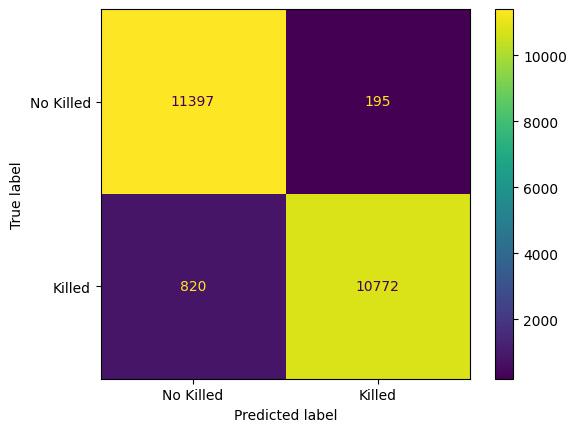

In [119]:
report_confusion_matrix(test_label, test_pred)